#Python Gaussian Analysis Tool (pygauss)

Pygauss is designed to be an API for parsing one or more input/output files from a [Gaussian](http://www.gaussian.com/) quantum chemical computation and provide functionality to assess  **molecular geometry** and **electronic distribution** both visually and quantitatively.

It is built on top of the [cclib](http://cclib.github.io/)/[chemlab](http://chemlab.readthedocs.org/en/latest/index.html)/[chemview](http://chemview.readthedocs.org/en/latest/) suite of packages and python scientific stack and is primarily designed to be used interactively in the [IPython Notebook](http://ipython.org/notebook.html) (within which this readme has been written). As shown below, a molecular optimisation can be assesed individually (much like in [gaussview](http://www.gaussian.com/g_prod/gv5b.htm)), but also as part of a group. The advantages of this package are then:

- Faster, more efficient analysis
- Reproducible analysis
- Trend analysis

Detail instillation...

    pip install pygauss
    
    conda install -c http://conda.binstar.org/gabrielelanaro chemlab

In [8]:
from IPython.display import display
%matplotlib inline
import pygauss as pg
folder = pg.get_test_folder()

##Single Molecule Analysis

A *molecule* can be created containg data about the inital geometry, optimisation process and analysis of the final configuration.

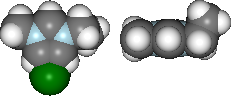

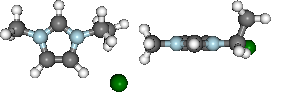

In [42]:
mol = pg.molecule.Molecule(folder,
                init_fname='CJS1_emim-cl_B_init.com', 
                opt_fname=['CJS1_emim-cl_B_6-311+g-d-p-_gd3bj_opt-modredundant_difrz.log',
                           'CJS1_emim-cl_B_6-311+g-d-p-_gd3bj_opt-modredundant_difrz_err.log',
                           'CJS1_emim-cl_B_6-311+g-d-p-_gd3bj_opt-modredundant_unfrz.log'],
                freq_fname='CJS1_emim-cl_B_6-311+g-d-p-_gd3bj_freq_unfrz.log',
                nbo_fname='CJS1_emim-cl_B_6-311+g-d-p-_gd3bj_pop-nbo-full-_unfrz.log', 
                alignto=[3,2,1])

#mol.show_initial(active=True)
display(mol.show_initial(zoom=0.5, rotations=[[0,0,90], [-90, 90, 0]]))
display(mol.show_optimisation(ball_stick=True, rotations=[[0,0,90], [-90, 90, 0]]))

Basic analysis of optimisation...

Optimised? True, Conformer? True, Energy = -805.105 a.u.


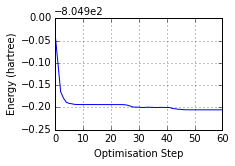

In [35]:
print('Optimised? {0}, Conformer? {1}, Energy = {2} a.u.'.format(
    mol.is_optimised(), mol.is_conformer(), round(mol.get_optimisation_E(units='hartree'),3)))
ax = mol.plot_optimisation_E(units='hartree')
ax.get_figure().set_size_inches(3, 2)

Geometric analysis...

Cl optimised polar coords from aromatic ring : (0.11, -116.42,-170.06)


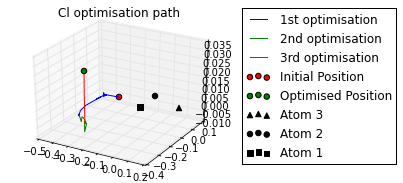

In [62]:
print 'Cl optimised polar coords from aromatic ring : ({0}, {1},{2})'.format(
    *[round(i, 2) for i in mol.calc_polar_coords_from_plane(20,3,2,1)])
ax = mol.plot_opt_trajectory(20, [3,2,1])
ax.set_title('Cl optimisation path')
ax.get_figure().set_size_inches(4, 3)

Potential Energy Scan analysis of geometric conformers...

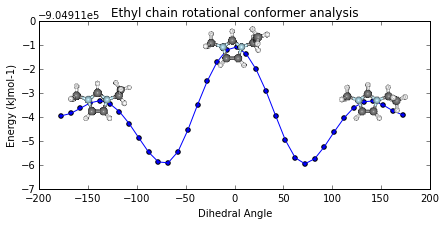

In [61]:
mol2 = pg.molecule.Molecule(folder, alignto=[3,2,1],
            pes_fname=['CJS_emim_6311_plus_d3_scan.log', 
                       'CJS_emim_6311_plus_d3_scan_bck.log'])   
ax = mol2.plot_pes_scans([1,4,9,10], rotation=[0,0,90], img_pos='local_maxs', zoom=0.5)
ax.set_title('Ethyl chain rotational conformer analysis')
ax.get_figure().set_size_inches(7, 3)

Natural Bond Orbital analysis...

+ve charge centre polar coords from aromatic ring: (0.02 -51.77,-33.15)


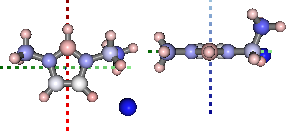

In [59]:
print '+ve charge centre polar coords from aromatic ring: ({0} {1},{2})'.format(
    *[round(i, 2) for i in mol.calc_nbo_charge_center(3, 2, 1)])
display(mol.show_nbo_charges(ball_stick=True, axis_length=0.4, 
                              rotations=[[0,0,90], [-90, 90, 0]]))

## Multiple Computations Analysis

a

In [104]:
analysis = pg.analysis.Analysis(folder)
df, errors = analysis.add_runs(headers=['Cation', 'Anion', 'Initial'], 
                               values=[['emim'], ['cl'],
                                       ['B', 'BE', 'BM', 'F', 'FE', 'FM']],
            init_pattern='CJS1_{0}-{1}_{2}_init.com',
            opt_pattern='CJS1_{0}-{1}_{2}_6-311+g-d-p-_gd3bj_opt-modredundant_unfrz.log',
            freq_pattern='CJS1_{0}-{1}_{2}_6-311+g-d-p-_gd3bj_freq_unfrz.log',
            nbo_pattern='CJS1_{0}-{1}_{2}_6-311+g-d-p-_gd3bj_pop-nbo-full-_unfrz.log')
print 'Read Errors:', errors

Read Errors: [{'Cation': 'emim', 'Initial': 'FM', 'Anion': 'cl'}]


In [105]:
analysis.add_mol_property('Opt', 'is_optimised')
analysis.add_mol_property('Energy (au)', 'get_optimisation_E', units='hartree')
analysis.add_mol_property('Cation chain, $\\psi$', 'calc_dihedral_angle', [1, 4, 9, 10])
analysis.add_mol_property('Cation Charge', 'calc_nbo_charge', range(1, 20))
analysis.add_mol_property('Anion Charge', 'calc_nbo_charge', [20])
analysis.add_mol_property(['Anion-Cation, $r$', 'Anion-Cation, $\\theta$', 'Anion-Cation, $\\phi$'], 
                               'calc_polar_coords_from_plane', 3, 2, 1, 20)
analysis.get_table(row_index=['Anion', 'Cation', 'Initial'], 
                   column_index=['Cation', 'Anion', 'Anion-Cation'])

Cation         Anion  \
                       Opt Energy (au) chain, $\psi$ Charge Charge   
Anion Cation Initial                                                 
cl    emim   B        True    -805.105        80.794  0.888 -0.888   
             BE       True    -805.105        80.622  0.887 -0.887   
             BM       True    -805.104        73.103  0.874 -0.874   
             F        True    -805.118       147.026  0.840 -0.840   
             FE       True    -805.117        85.310  0.851 -0.851   

                     Anion-Cation                     
                              $r$  $\theta$   $\phi$  
Anion Cation Initial                                  
cl    emim   B              0.420  -123.392  172.515  
             BE             0.420  -123.449  172.806  
             BM             0.420   124.121 -166.774  
             F              0.420    10.393    0.728  
             FE             0.417   -13.254   -4.873

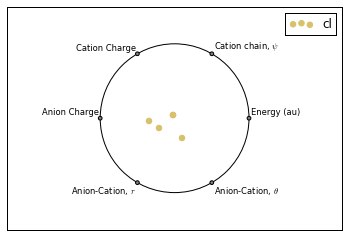

In [86]:
ax = analysis.plot_radviz_comparison('Anion', columns=range(4, 10))

Category 0:
(row 0)


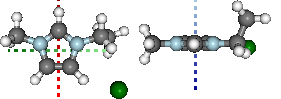

(row 1)


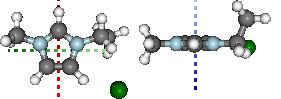

Category 1:
(row 2)


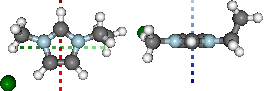

Category 2:
(row 3)


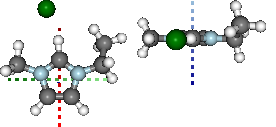

Category 3:
(row 4)


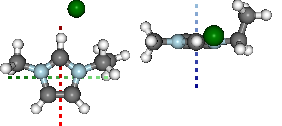

In [89]:
kwargs = {'mtype':'optimised', 'align_to':[3,2,1], 
            'rotations':[[0, 0, 90], [-90, 90, 0]],
            'axis_length':0.3}
def show_groups(df):
    for cat, gf in df.groupby('Category'):
        print 'Category {0}:'.format(cat)
        mols = analysis.yield_mol_images(rows=gf.index.tolist(), **kwargs)
        for mol, row in zip(mols, gf.index.tolist()): 
            print '(row {0})'.format(row)
            display(mol)
show_groups(analysis.calc_kmean_groups('Anion', 'cl', 4, columns=range(4, 10)))